### Comments

**TO DO**
* Batch?!
* fine tuning des params --> pas optimisé pour le moment => optimisation done parametres semblables a avant
* try different architecture -> testé combinaison de linear et GCNN / APPNP => GCNN avec une linear avant et deux linear apres = best
* Use genre as features and build network on Cast, Crew, Keywords?
* Skip Connections ? Batch Norm ? 
* Standardiser ameliores performances et balance des errors + stabilise learning

# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import random

import dgl.function as fn
from dgl import DGLGraph
import dgl.nn.pytorch as dgl_nn
import dgl.transform as dgl_transform

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

Data_path = 'Data/'

### Loading the similarity matrix and generate graph

In [2]:
# Load similarity matrix
#file = open(Data_path + 'Adjacency_matrix.pickle','rb')
#file = open(Data_path + 'Adjacency_matrix_G99CCK05.pickle', 'rb')
file = open(Data_path + 'Adjacency_matrix_all025.pickle', 'rb')
adj_mat =  pickle.load(file)

# Generate graph
G = DGLGraph(graph_data=adj_mat)
G = dgl_transform.add_self_loop(G)

### Loading features and labels

In [3]:
features_df = pd.read_csv(Data_path + 'features.csv',index_col=0).drop(columns = ['title'])

labels_df = pd.read_csv(Data_path + 'labels.csv',index_col=0).drop(columns = ['title', ])

keep only some features

In [4]:
features_df = features_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]

The labels is whether the movie is nominated for an Oscare or a GoldenGlobes 

In [5]:
# features
#tensor_data = torch.FloatTensor(features_df.values)

# labels
IMDB_nom = labels_df['Nominations'].copy()
IMDB_nom.loc[IMDB_nom > 0] = 1
#tensor_labels = torch.LongTensor(IMDB_nom.values)

In [6]:
# Just checking class imbalance
IMDB_nom.value_counts() # 18.263 % of CLASS 1

0.0    3728
1.0    1074
Name: Nominations, dtype: int64

In [ ]:
'''# Separate majority and minority classes
df_majority = IMDB_nom[IMDB_nom==0]
df_minority = IMDB_nom[IMDB_nom==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=877,     # to match minority class
                                 random_state=1) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.value_counts()
# 1    49
# 0    49
# Name: balance, dtype: int64

adj_mat_bal = adj_mat[df_downsampled.index,:]
adj_mat_bal = adj_mat_bal[:,df_downsampled.index]
G = DGLGraph(graph_data=adj_mat_bal)

G = dgl_transform.add_self_loop(G)

tensor_feat = torch.FloatTensor(features_df.iloc[df_downsampled.index,:].values)
tensor_labels = torch.LongTensor(df_downsampled.values)'''

### Generate masks and split train, val, test

In [7]:
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=0)

for prov_index, test_index in sss1.split(features_df, IMDB_nom.values):
    prov_mask = prov_index
    test_mask = test_index

for train_index, val_index in sss2.split(features_df.iloc[prov_mask], IMDB_nom.values[prov_mask]):
    train_mask = train_index
    val_mask = val_index

### Standardize and create tensors

In [8]:
# Standardizing the data increases performances (73 -> 82), in terms of repartition bit more imbalanced
# but still increase of performance for class 1 samples
scaler = StandardScaler()
features_df.iloc[train_mask] = scaler.fit_transform(features_df.iloc[train_mask].to_numpy())
features_df.iloc[val_mask] = scaler.transform(features_df.iloc[val_mask].to_numpy())
features_df.iloc[test_mask] = scaler.transform(features_df.iloc[test_mask].to_numpy())

In [22]:
features_df.iloc[test_mask] = scaler.transform(features_df.iloc[test_mask].to_numpy())

In [9]:
# features
tensor_data = torch.FloatTensor(features_df.values)

# labels
IMDB_nom = labels_df['Nominations'].copy()
IMDB_nom.loc[IMDB_nom > 0] = 1
tensor_labels = torch.LongTensor(IMDB_nom.values)

In [10]:
# Just checking class imbalance
IMDB_nom.value_counts() # 18.263 % of CLASS 1

0.0    3728
1.0    1074
Name: Nominations, dtype: int64

### Building Logistic Regression

In [11]:
# PCA without feature selection not significant impact
#pca = PCA(n_components=features_df.shape[1])
#features_df.iloc[train_mask] = pca.fit_transform(features_df.iloc[train_mask].to_numpy())
#features_df.iloc[val_mask] = pca.transform(features_df.iloc[val_mask].to_numpy())

In [12]:
clf = LogisticRegression(C= 1,random_state = 0,solver = 'lbfgs').fit(features_df.iloc[train_mask].to_numpy() ,IMDB_nom.values[train_mask])
train_score = clf.score(features_df.iloc[train_mask].to_numpy(),IMDB_nom.values[train_mask])
val_score = clf.score(features_df.iloc[val_mask].to_numpy(),IMDB_nom.values[val_mask])

print('>>>>> Training Accuracy of Logistic Regression: {:0.4}'.format(train_score))
print('>>>>> Validation Accuracy of Logistic Regression: {:0.4}'.format(val_score))
print('>>>>> Proportion of validation class 1: {:0.4}'.format(np.sum(IMDB_nom.values[val_mask])/len(IMDB_nom.values[val_mask])))
print('>>>>> Proportion of predicted class 1: {:0.4}'.format(np.sum(clf.predict(features_df.iloc[val_mask]))/len(IMDB_nom.values[val_mask])))


>>>>> Training Accuracy of Logistic Regression: 0.82
>>>>> Validation Accuracy of Logistic Regression: 0.7997
>>>>> Proportion of validation class 1: 0.2471
>>>>> Proportion of predicted class 1: 0.1717


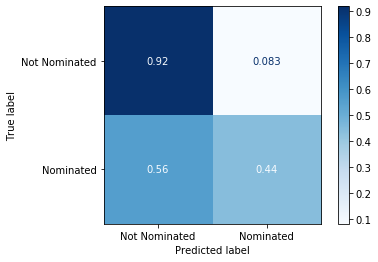

In [13]:
# Confusion Matrix on validation classification
disp = sklearn.metrics.plot_confusion_matrix(clf, features_df.iloc[val_mask],IMDB_nom.values[val_mask],cmap=plt.cm.Blues,display_labels = ['Not Nominated','Nominated'],normalize='true')


### Building Logistic Regression & Graph Filtering

##### Results of optimisation : 

Optimisation performed by looking at validation accuracy and distribution of errors across classes using confusion matrix
- polynomial order : increase of the order tends to increase the instability of performances accross epochs, no strong impact on filter final shape -> tradeoff complexity/stability at 3
- learning rate: small shift towards very unbalanced error, higher learning rate enabled to get a better trade-off between accuracy and distribution of error -> 0.2
- number of epochs : event of strong instabilities across trials whatever parameters; strong instabilities allows better balance of errors but weaker accuracies; around 1500 period of stable learning
- dropout : increase generates instabilities, tradeoff between accuracy and distribution of errors at 0.
=> Final filter is basically always the same sort of shape as shown below

In [14]:
# Plot confusion matrix when classifier not available only confusion matrix
def confusion_matrix(matrix):
    figure = plt.figure()
    axes = figure.add_subplot(111)
    test = axes.matshow(matrix, cmap = plt.cm.get_cmap('Blues'));
    axes.set_yticklabels(['','Not Nominated','Nominated'],style='italic')
    axes.set_xticklabels(['','Not Nominated','Nominated'],style='italic')
    axes.set_ylabel('True Label')
    axes.set_xlabel('Predicted Label')
    figure.colorbar(test)
    for (j,i),label in np.ndenumerate(matrix):
        axes.text(i,j,np.round(label,3),ha='center',va='center',color = 'grey')
    plt.show()

In [15]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights) # X*Teta

        result = self.pol_weights[0] * feat.clone() # a0*L^0*X*Teta <-- fisrt polynomial weight a0 * L^0 * x

        for i in range(1, self._k + 1): # get the next polynomial coefficient (a1*L^1, a2*L^2, ..... ak*L^k) 
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h')) # update all nodes with msg function copy_src (get data from source node) and reduce function sum
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [16]:
def train(model, g, features, labels, train_mask, loss_fcn, optimizer):
    """ 
    DESCRIPTION : Train and update model classification performances with training set
    INPUT:
        |--- model: [] classification model to train
        |--- g: [DGLgraph] DeepGraphLearning graph object
        |--- features: [FloatTensor] 2D tensor containing samples' features
        |--- labels: [LongTensor] 1D tensor containing samples' labels (0-1)
        |--- train_mask: [np.array] indices of training set
        |--- loss_fcn: pytorch loss function chosen for model training
        |--- optimizer: pytorch model optimizer 
    OUTPUT:
        |--- loss: [float] value of loss function for the model at current state
    """
    model.train()  
    
    pred = model(g, features)[train_mask] # prediction
    loss = loss_fcn(pred, labels[train_mask])
    optimizer.zero_grad()    
    loss.backward()

    optimizer.step()
    _, indices = torch.max(pred, dim=1)
    correct = torch.sum(indices == labels[train_mask])
    acc = correct.item() * 1.0 / len(labels[train_mask]) #not the best metric
    
    C = sklearn.metrics.confusion_matrix(tensor_labels[train_mask], indices.numpy(), labels=[0,1], sample_weight=None, normalize='true')

    return loss, acc, C
    
def evaluate(model, g, features, mask, labels):
    """ 
    DESCRIPTION : Evaluate model classification performance on validation set 
    INPUT:
        |--- model: [] classification model to evaluate
        |--- g: [DGLgraph] DeepGraphLearning graph object
        |--- features: [FloatTensor] 2D tensor containing samples' features
        |--- labels: [LongTensor] 1D tensor containing samples' labels (0-1)
        |--- mask: [np.array] indices of validation set
    OUTPUT:
        |--- acc: [float] classification accuracy
        |--- recall: [float] classification recall
        |--- precision: [float] classification precision
        |--- f1: [float] classification f1 score
    """
    model.eval() 
    
    with torch.no_grad():
        pred = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(pred, dim=1)
        correct = torch.sum(indices == labels)
        acc = correct.item() * 1.0 / len(labels) #not the best metric
        f1 = f1_score(labels, indices)
        recall = recall_score(labels, indices)
        precision = precision_score(labels, indices)
        
        C = sklearn.metrics.confusion_matrix(labels, indices.numpy(), labels=[0,1], sample_weight=None, normalize='true')
        
        return acc, recall, precision, f1, C

In [17]:
pol_order = 3  # seems like a good trade off between performance and instability, increasing does give more
lr = 0.3 # allows to get a good tradeoff between error distribution and accuracy
weight_decay = 5e-6
n_epochs = 500 
p_dropout = 0.32  # 0.32 very good balancing, 75%, 0.3 balacing a bit less, 77%
n_classes = 2
in_feats=tensor_data.shape[1]

Epoch 00100 | Time(s) 0.0182 | Train Loss 652.0535 | Val Accuracy 72.3017%
Epoch 00200 | Time(s) 0.0184 | Train Loss 0.8414 | Val Accuracy 69.3108%
Epoch 00300 | Time(s) 0.0183 | Train Loss 0.4941 | Val Accuracy 76.8531%
Epoch 00400 | Time(s) 0.0182 | Train Loss 0.4966 | Val Accuracy 77.1131%
Epoch 00500 | Time(s) 0.0182 | Train Loss 0.4972 | Val Accuracy 77.1131%



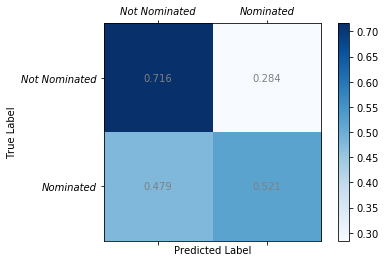

Test Accuracy 67.2216%


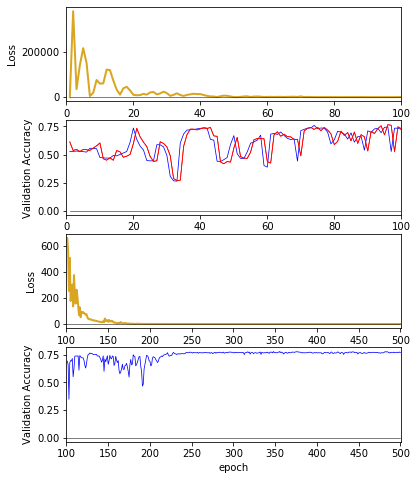

In [24]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
losses = []
accuracies_val = []
accuracies_tr = []
for epoch in range(n_epochs):

    t0 = time.time()
    loss, acc, C = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
    losses.append(loss)
    accuracies_tr.append(acc)
    dur.append(time.time() - t0)

    acc, recall, precision, f1, C = evaluate(model, G, tensor_data, val_mask, tensor_labels)
    accuracies_val.append(acc)
    if (epoch+1)%100 == 0:
        print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4%}". format(epoch+1, np.mean(dur), loss.item(), acc))

print()
acc, recall, precision, f1, C = evaluate(model, G, tensor_data, test_mask, tensor_labels)
confusion_matrix(C)
print("Test Accuracy {:.4%}".format(acc))


# Plot the loss
fig, axs = plt.subplots(4,1,figsize=(6,8))
ep = np.arange(1,n_epochs+1,1)
axs[0].plot(ep[0:100], losses[0:100], color='Goldenrod', linewidth=2)
axs[0].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[0].set_xlim([0,100])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(ep[0:100], accuracies_val[0:100], color='blue', linewidth=0.75)
axs[1].plot(ep[0:100], accuracies_tr[0:100], color='red', linewidth=0.75)
axs[1].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[1].set_xlim([0,100])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Validation Accuracy')

axs[2].plot(ep[100:], losses[100:], color='Goldenrod', linewidth=2)
axs[2].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[2].set_xlim([100,n_epochs+1])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('Loss')

axs[3].plot(ep[100:], accuracies_val[100:], color='blue', linewidth=0.75)
axs[1].plot(ep[0:100], accuracies_tr[0:100], color='red', linewidth=0.75)
axs[3].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[3].set_xlim([100,n_epochs+1])
axs[3].set_xlabel('epoch')
axs[3].set_ylabel('Validation Accuracy')

plt.show()

# instabilite au file des epochs -> more balanced, less performant

In [19]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ 
        DESCRIPTION : Compute response of filtering using a polynomial filter 
        INPUT:
            |--- coeff: [np.array] coeffiicients of polynomial filter
            |--- lam: [np.ndarray] eigenvalues 
        OUTPUT:
            |--- response: [np.ndarray] response[i] is the spectral response at frequency lam[i]
    """
    V = np.vander(lam,coeff.shape[0],increasing=True)
    response = V@coeff
    return response

In [20]:
def spectral_decomposition(laplacian: np.ndarray):
    """ 
        DESCRIPTION : Compute spectral decomposition of a graph using the graph Laplacian
        INPUT:
            |--- laplacian: [np.ndarray] graph laplacian 
        OUTPUT:
            |--- lamb: [np.ndarray] containing graph eigenvalues
            |--- U: [np.ndarray] containing corresponding graph eigenvectors
    """
    # compute the eigenvalues and eigenvectors
    if np.allclose(laplacian, laplacian.T, 1e-12):
        lamb, U = np.linalg.eigh(laplacian)
    else:
        lamb, U = np.linalg.eig(laplacian)
        #sort them
        idx = np.argsort(lamb, axis=0)
        lamb = lamb[idx]
        U = U[:,idx]
    
    return lamb, U

In [21]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ 
        DESCRIPTION : Compute spectral decomposition of a graph using the graph Laplacian
        INPUT:
            |--- adjacency: [np.ndarray] adjacency matrix of the graph
            |--- normalize: [bool] if normalize laplacian or not
        OUTPUT:
            |--- L: [n x n ndarray] combinatorial or symmetric normalized Laplacian. of the graph 
    """
    # degrees
    I = np.identity(adjacency.shape[0])
    degree = np.sum(adjacency, axis=1)
    # Compute laplacian
    D = I.copy()
    np.fill_diagonal(D, degree)
    L = D - adjacency
    # normalized if requested 
    if normalize:
        D12 = np.where(D > 0, np.power(D, -0.5, where=D>0), 0)
        L = D12 @ L @ D12
        
    return L

In [25]:
L_norm = compute_laplacian(adjacency =adj_mat, normalize = True)
lamb_, _ = spectral_decomposition(laplacian = L_norm)

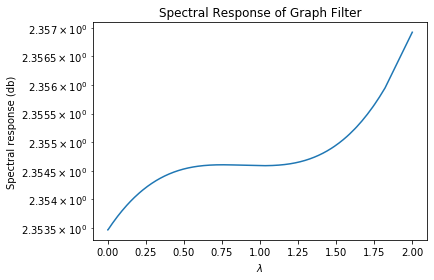

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(lamb_,np.abs(polynomial_graph_filter_response(model.pol_weights.detach().numpy(), lamb_)))
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Spectral response (db)')
ax.set_title('Spectral Response of Graph Filter')
plt.show()

### Building Graph Neural Network

In [27]:
#  model: Combine GraphConv layers first then two fully connected layers --> seems less stable over epochs
class Linear_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = 24
        
        # Layers --> as much GraphConv as diameter --> reach everywhere
        layer_size = 64
        self.linear = nn.Linear(self._in_feats, layer_size)
        self.gcn1 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.linear1 = nn.Linear(layer_size, self._out_feats)
        #self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = F.relu(self.linear(feat))
        h = self.gcn1(graph, h)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = self.linear1(h)
        #h = F.relu(h)
        #h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

# Model : Only GraphConv layers --> seems more stable
class Pure_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.gcn1 = dgl_nn.conv.GraphConv(self._in_feats, 32, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(32, 32, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(32,  self._out_feats, activation=None)
        
    def forward(self, graph, feat):
        h = self.gcn1(graph, feat)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = F.log_softmax(h, dim=1)
        return h 

# model : Use and APPNP layer with k=7 (the network diameter) followed by 2 fully connected linears. 
class Simple_APPNP(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, hidden_size: int, k: int):
        super().__init__()
        self._k = k
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._hidden_size = hidden_size
        
        # Layers
        self.appnpconv1 = dgl_nn.conv.APPNPConv(self._k, 0.1, 0) #alpha teleport proba = 0.1 (cf paper)
        self.linear1 = nn.Linear(self._hidden_size, self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = self.appnpconv1(graph, feat)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 


In [28]:
# check network diameter --> take a lot of time to run => diameter 11
import networkx as nx
Gnx = nx.from_numpy_array(adj_mat)
G_large = max(nx.connected_component_subgraphs(Gnx), key=len)
d = nx.diameter(G_large) 
print(f'diameter : {d}')

diameter : 11


In [29]:
# Fixed values
in_feats = tensor_data.shape[1]
out_feats = 2

# Not relevant parameters
n_epochs = 200
# To tune
k = 11 # number of hop (how far to look) usually best to use the network diameter (according to paper)
lr = 1e-4
lr2 = 2e-5
lr3 = 8e-6
#weight_decay = 5e-6
#p_dropout = 0 # for now not doing it

hidden_size = 128
true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance

/Users/alicebizeul/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1. 0.]
 [1. 0.]]
Epoch 10 | Train Loss 72.521 | Val Accuracy 75.2926% | Val recall  0.0000% |  Val  precision 0.0000% | Val f1 0.0000% |
[[0.99481865 0.00518135]
 [0.98421053 0.01578947]]
Epoch 20 | Train Loss 73.281 | Val Accuracy 75.2926% | Val recall  1.5789% |  Val  precision 50.0000% | Val f1 3.0612% |
[[1. 0.]
 [1. 0.]]
Epoch 30 | Train Loss 41.597 | Val Accuracy 75.2926% | Val recall  0.0000% |  Val  precision 0.0000% | Val f1 0.0000% |
[[1. 0.]
 [1. 0.]]
Epoch 40 | Train Loss 14.334 | Val Accuracy 75.2926% | Val recall  0.0000% |  Val  precision 0.0000% | Val f1 0.0000% |
[[0.99827288 0.00172712]
 [1.         0.        ]]
Epoch 50 | Train Loss 13.404 | Val Accuracy 75.1625% | Val recall  0.0000% |  Val  precision 0.0000% | Val f1 0.0000% |
[[0.22970639 0.77029361]
 [0.11578947 0.88421053]]
Epoch 60 | Train Loss 3.334 | Val Accuracy 39.1417% | Val recall  88.4211% |  Val  precision 27.3616% | Val f1 41.7910% |
[[0.46804836 0.53195164]
 [0.28421053 0.71578947]]
Epoch 70 | Train

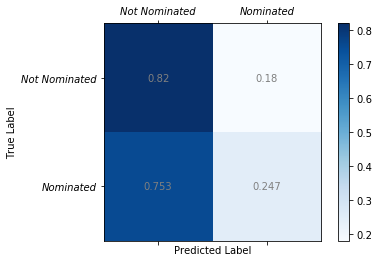

Test 
 	|---- Accuracy 69.1988% 
 	|---- Recall 24.6512% 
 	|---- Precision 28.3422% 
 	|---- F1-score 26.3682%


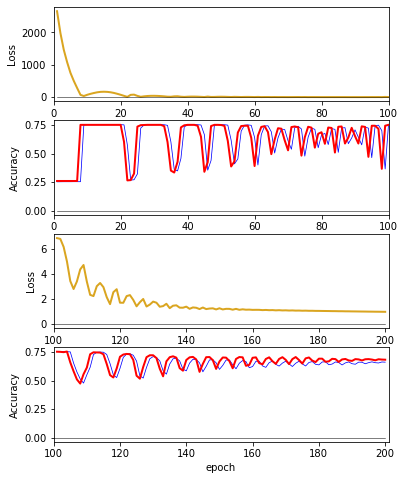

In [30]:
model = Linear_GNN(in_feats, out_feats, hidden_size)
#model = Simple_APPNP(in_feats, out_feats, 6, k)

loss_fcn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr) #weight_decay=weight_decay)
losses_tr = []
accuracies_tr = []
accuracies_val = []
for epoch in range(n_epochs):
    # adapt learning rate
    if epoch == 100: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr2
    elif epoch == 300: 
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr3
    
    loss, acc, C_tr = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
    losses_tr.append(loss.item())
    accuracies_tr.append(acc)
    acc, recall, precision, f1, C_val = evaluate(model, G, tensor_data, val_mask, tensor_labels)
    accuracies_val.append(acc)

    if (1+epoch)%10 == 0:
        print(C_val)
        print(f"Epoch {epoch+1} | Train Loss {loss.item():.3f} |", \
                f"Val Accuracy {acc:.4%} | Val recall  {recall:.4%} |", \
                f" Val  precision {precision:.4%} | Val f1 {f1:.4%} |")

acc, recall, precision, f1, C = evaluate(model, G, tensor_data, test_mask, tensor_labels)
confusion_matrix(C)
print(f"Test \n \t|---- Accuracy {acc:.4%} \n \t|---- Recall {recall:.4%} \n \t|---- Precision {precision:.4%} \n \t|---- F1-score {f1:.4%}")

# Plot the loss
fig, axs = plt.subplots(4,1,figsize=(6,8))
ep = np.arange(1,n_epochs+1,1)
axs[0].plot(ep[0:100], losses_tr[0:100], color='Goldenrod', linewidth=2)
axs[0].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[0].set_xlim([0,100])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(ep[0:100], accuracies_tr[0:100], color='blue', linewidth=0.75)
axs[1].plot(ep[0:100], accuracies_val[0:100], color='red', linewidth=2)
axs[1].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[1].set_xlim([0,100])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')

axs[2].plot(ep[100:], losses_tr[100:], color='Goldenrod', linewidth=2)
axs[2].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[2].set_xlim([100,n_epochs+1])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('Loss')

axs[3].plot(ep[100:], accuracies_tr[100:], color='blue', linewidth=0.75)
axs[3].plot(ep[100:], accuracies_val[100:], color='red', linewidth=2)
axs[3].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[3].set_xlim([100,n_epochs+1])
axs[3].set_xlabel('epoch')
axs[3].set_ylabel('Accuracy')

plt.show()

### Results of Graph CNN Optimisation : 

- APP Conv : with or without linear layer added generates a linearly decreasing loss and associated linearly decreasing accuracy with no good repartition of error between classes, difficulty to learn
- GCNN without linear layers: more unstable results, no learning 
- GCNN with linear layers: linear layer at the beginning help stabilize and learn, a second linear layer in front doesn't create significant impact |no linear layer at the end no learning, second linear layer at the end reduces learning/less balanced errors, performance around 75%
- Number of CNN layers: the addition of layers helps stabilize the learning accross epochs, when 4/5 layers less stables hence ~66% with more balanced, when 10/11 layers after 200 epochs very stales, errors not balanced at all
- Add dropout, increase instability, when in a max -> strong acc, bad repartition, when in a min, the opposite => removed 
- Addition of a Avgpooling layer: no significant improvement on accuracy or error repartition 
- Hidden layer size for GCNN: if increase layer size increase creates instability but at a certain extend balances the errors in classes, around 60
- Hidden layer size for final linear layer: 30, tradeoff with error-accuracy
- Cross entropy + Soft Max give very unstable results over trials, converge to all 0 or all 1
- NLL loss with log_sofmax gives very unstable results over epochs but reaches learning
- Adding weights to loss function does generate improvement 
- BCE Loss not appropriate
- Number of epochs, no need to go above 250, stabilisation around 200/250

=> if stable , accuracy around 75%, very unbalanced errors
=> if unstable (less layers, dropout ...), accuracy around 60%, more balanced errors 
